# 02 - Exploratory Data Analysis (EDA)

## Objective
- Explore relationships between features and Attrition
- Identify patterns that may explain employee turnover
- Generate hypotheses for feature engineering
- Support downstream modeling decisions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

In [2]:
df = pd.read_csv("../data/interim/hr_employee_attrition_audit_clean.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


In [3]:
target_counts = df["Attrition"].value_counts()
target_pct = (df["Attrition"].value_counts(normalize=True) * 100).round(2)

target_counts, target_pct

(Attrition
 No     1233
 Yes     237
 Name: count, dtype: int64,
 Attrition
 No     83.88
 Yes    16.12
 Name: proportion, dtype: float64)

## Target Overview (Attrition)

- No: 1233 (83.88%)
- Yes: 237 (16.12%)

This indicates a meaningful class imbalance. For later modeling, we will avoid relying on accuracy alone and will prioritize metrics that reflect minority-class performance (precision, recall, F1, ROC-AUC). For EDA, we will focus on segment-level attrition rates to identify actionable drivers.

In [4]:
target_col = "Attrition"

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != target_col]

num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

len(cat_cols), len(num_cols), cat_cols[:10], num_cols[:10]

(7,
 23,
 ['BusinessTravel',
  'Department',
  'EducationField',
  'Gender',
  'JobRole',
  'MaritalStatus',
  'OverTime'],
 ['Age',
  'DailyRate',
  'DistanceFromHome',
  'Education',
  'EnvironmentSatisfaction',
  'HourlyRate',
  'JobInvolvement',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome'])

## Feature Groups for EDA

Based on data types after audit cleaning:

- Categorical features (7):
  - BusinessTravel
  - Department
  - EducationField
  - Gender
  - JobRole
  - MaritalStatus
  - OverTime

- Numerical features (23):
  - Includes true continuous variables (e.g., Age, MonthlyIncome)
  - Includes ordinal scales stored as integers (e.g., Education, JobLevel, satisfaction scores)

EDA will be structured by feature group to avoid redundant or low-signal analysis and to directly support feature engineering decisions.

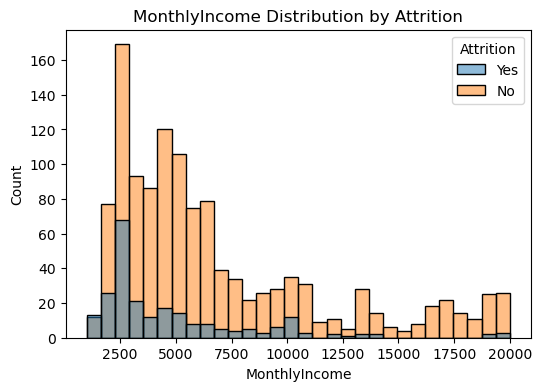

C:\Users\alikm\AppData\Local\Temp\ipykernel_12092\1697832615.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_income.groupby("income_quartile")["Attrition"]


income_quartile
(1008.999, 2911.0]    29.27
(2911.0, 4919.0]      14.21
(4919.0, 8379.0]      10.63
(8379.0, 19999.0]     10.33
Name: Attrition, dtype: float64

In [5]:
# Distribution
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="MonthlyIncome", hue="Attrition", bins=30, kde=False, ax=ax)
ax.set_title("MonthlyIncome Distribution by Attrition")
plt.show()

# Attrition rate by income quartile
df_income = df.copy()
df_income["income_quartile"] = pd.qcut(df_income["MonthlyIncome"], q=4)

income_attrition_rate = (
    df_income.groupby("income_quartile")["Attrition"]
    .apply(lambda x: (x == "Yes").mean() * 100)
    .round(2)
)

income_attrition_rate

## MonthlyIncome vs Attrition (Distribution and Quartiles)

The attrition rate decreases sharply as MonthlyIncome increases.

Attrition rate by income quartile:
- Q1 (lowest income): 29.27%
- Q2: 14.21%
- Q3: 10.63%
- Q4 (highest income): 10.33%

Key takeaway:
- The lowest-income segment has roughly 2x to 3x higher attrition than the rest of the population.
- The relationship is clearly non-linear (the biggest drop occurs between Q1 and Q2).

In [6]:
df_tmp = df.copy()
df_tmp["income_quartile"] = pd.qcut(df_tmp["MonthlyIncome"], q=4)

pivot = pd.pivot_table(
    df_tmp,
    values="Attrition",
    index="income_quartile",
    columns="OverTime",
    aggfunc=lambda x: (x == "Yes").mean() * 100,
).round(2)

pivot

C:\Users\alikm\AppData\Local\Temp\ipykernel_12092\1059388560.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = pd.pivot_table(


OverTime,No,Yes
income_quartile,,
"(1008.999, 2911.0]",17.49,58.49
"(2911.0, 4919.0]",10.00,26.04
"(4919.0, 8379.0]",6.98,19.27
"(8379.0, 19999.0]",7.22,18.10


## Interaction Check: MonthlyIncome Quartile x OverTime

Attrition rate (%) by income quartile and OverTime:

- Lowest income quartile:
  - OverTime = No: 17.49
  - OverTime = Yes: 58.49

- Second quartile:
  - OverTime = No: 10.00
  - OverTime = Yes: 26.04

- Third quartile:
  - OverTime = No: 6.98
  - OverTime = Yes: 19.27

- Highest quartile:
  - OverTime = No: 7.22
  - OverTime = Yes: 18.10

Key takeaway:
- OverTime is a strong driver across all income levels.
- The combination of low income and OverTime is particularly high risk (58.49% attrition in the lowest income quartile with OverTime).

In [7]:
df_tmp = df.copy()

bins = [-0.1, 0, 1, 3, 5, 10, 20, 40]
labels = ["0", "1", "2-3", "4-5", "6-10", "11-20", "21-40"]
df_tmp["tenure_bucket"] = pd.cut(df_tmp["YearsAtCompany"], bins=bins, labels=labels)

tenure_rate = (
    df_tmp.groupby("tenure_bucket")["Attrition"]
    .apply(lambda x: (x == "Yes").mean() * 100)
    .round(2)
)

tenure_counts = df_tmp["tenure_bucket"].value_counts().sort_index()

tenure_counts, tenure_rate

C:\Users\alikm\AppData\Local\Temp\ipykernel_12092\2357422710.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tmp.groupby("tenure_bucket")["Attrition"]


(tenure_bucket
 0         44
 1        171
 2-3      255
 4-5      306
 6-10     448
 11-20    180
 21-40     66
 Name: count, dtype: int64,
 tenure_bucket
 0        36.36
 1        34.50
 2-3      18.43
 4-5      13.07
 6-10     12.28
 11-20     6.67
 21-40    12.12
 Name: Attrition, dtype: float64)

## YearsAtCompany vs Attrition (Tenure Buckets)

Employee counts by tenure bucket:
- 0 years: 44
- 1 year: 171
- 2-3 years: 255
- 4-5 years: 306
- 6-10 years: 448
- 11-20 years: 180
- 21-40 years: 66

Attrition rate (%) by tenure bucket:
- 0 years: 36.36
- 1 year: 34.50
- 2-3 years: 18.43
- 4-5 years: 13.07
- 6-10 years: 12.28
- 11-20 years: 6.67
- 21-40 years: 12.12

Key takeaway:
- Attrition is highest among the newest employees (0-1 year), then decreases as tenure increases.
- There is a clear non-linear pattern; early tenure is a distinct high-risk phase.
- The 21-40 bucket has a small sample size (66) and should be interpreted cautiously.

## Feature Ideas (from Tenure)

Candidate engineered features to validate later:
- tenure_bucket (categorical/ordinal bucket)
- is_new_hire (1 if YearsAtCompany <= 1)
- early_tenure_flag (1 if YearsAtCompany <= 3)
- income_per_tenure (MonthlyIncome / (YearsAtCompany + 1)) to capture "income growth vs tenure" signal

Rationale:
- The first 0-1 year period shows materially higher attrition rates than later buckets.
- Bucketing captures non-linear effects more robustly than treating tenure as purely linear.

In [8]:
df_tmp = df.copy()

bins = [-0.1, 0, 1, 3, 5, 10, 20, 40]
labels = ["0", "1", "2-3", "4-5", "6-10", "11-20", "21-40"]
df_tmp["tenure_bucket"] = pd.cut(df_tmp["YearsAtCompany"], bins=bins, labels=labels)

pivot_tenure_ot = pd.pivot_table(
    df_tmp,
    values="Attrition",
    index="tenure_bucket",
    columns="OverTime",
    aggfunc=lambda x: (x == "Yes").mean() * 100,
).round(2)

pivot_tenure_ot

C:\Users\alikm\AppData\Local\Temp\ipykernel_12092\4054852054.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_tenure_ot = pd.pivot_table(


OverTime,No,Yes
tenure_bucket,,
0,20.00,71.43
1,26.72,50.91
2-3,10.00,38.67
4-5,8.22,25.29
6-10,7.32,25.83
11-20,5.84,9.30
21-40,11.36,13.64


## Interaction Check: Tenure Bucket x OverTime

Attrition rate (%) by tenure bucket and OverTime:

- Tenure 0:
  - OverTime = No: 20.00
  - OverTime = Yes: 71.43
- Tenure 1:
  - OverTime = No: 26.72
  - OverTime = Yes: 50.91
- Tenure 2-3:
  - OverTime = No: 10.00
  - OverTime = Yes: 38.67
- Tenure 4-5:
  - OverTime = No: 8.22
  - OverTime = Yes: 25.29
- Tenure 6-10:
  - OverTime = No: 7.32
  - OverTime = Yes: 25.83
- Tenure 11-20:
  - OverTime = No: 5.84
  - OverTime = Yes: 9.30
- Tenure 21-40:
  - OverTime = No: 11.36
  - OverTime = Yes: 13.64

Key takeaway:
- OverTime increases attrition risk across all tenure buckets.
- The combination of early tenure and OverTime is especially high risk:
  - Tenure 0 with OverTime: 71.43%
  - Tenure 1 with OverTime: 50.91%

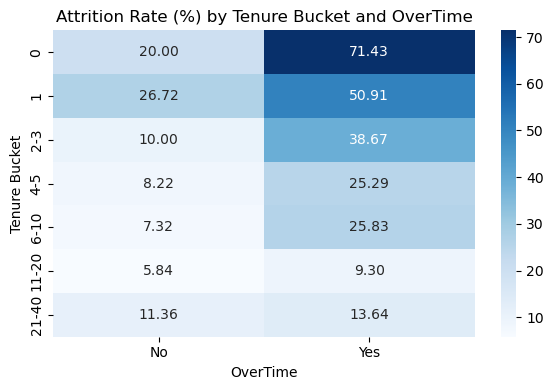

In [10]:
plt.figure(figsize=(6, 4))
sns.heatmap(pivot_tenure_ot, annot=True, fmt=".2f", cmap="Blues")
plt.title("Attrition Rate (%) by Tenure Bucket and OverTime")
plt.xlabel("OverTime")
plt.ylabel("Tenure Bucket")
plt.tight_layout()
plt.show()

## Visualization Summary: Tenure and OverTime Interaction

The heatmap confirms a strong interaction effect between tenure and OverTime:

- Attrition rates are consistently higher for employees with OverTime across all tenure buckets.
- The highest risk segments are clearly visible:
  - Tenure 0 with OverTime: 71.43%
  - Tenure 1 with OverTime: 50.91%
- Attrition risk decreases as tenure increases, especially for employees without OverTime.

This visualization reinforces the earlier numerical findings and highlights a small number of high-risk segments that are suitable for targeted retention strategies.

## Feature Candidates :
- income_quartile
- is_low_income
- tenure_bucket
- is_new_hire
- early_tenure_and_overtime
- overtime_flag

In [11]:
ordinal_cols = [
    "JobSatisfaction",
    "EnvironmentSatisfaction",
    "RelationshipSatisfaction",
    "WorkLifeBalance",
    "JobInvolvement",
]

ordinal_attrition = {}

for col in ordinal_cols:
    rate = (
        df.groupby(col)["Attrition"].apply(lambda x: (x == "Yes").mean() * 100).round(2)
    )
    ordinal_attrition[col] = rate

ordinal_attrition

{'JobSatisfaction': JobSatisfaction
 1    22.84
 2    16.43
 3    16.52
 4    11.33
 Name: Attrition, dtype: float64,
 'EnvironmentSatisfaction': EnvironmentSatisfaction
 1    25.35
 2    14.98
 3    13.69
 4    13.45
 Name: Attrition, dtype: float64,
 'RelationshipSatisfaction': RelationshipSatisfaction
 1    20.65
 2    14.85
 3    15.47
 4    14.81
 Name: Attrition, dtype: float64,
 'WorkLifeBalance': WorkLifeBalance
 1    31.25
 2    16.86
 3    14.22
 4    17.65
 Name: Attrition, dtype: float64,
 'JobInvolvement': JobInvolvement
 1    33.73
 2    18.93
 3    14.40
 4     9.03
 Name: Attrition, dtype: float64}

## Ordinal Scale Features vs Attrition

Attrition rate (%) by ordinal scale level:

JobSatisfaction:
- 1: 22.84
- 2: 16.43
- 3: 16.52
- 4: 11.33

EnvironmentSatisfaction:
- 1: 25.35
- 2: 14.98
- 3: 13.69
- 4: 13.45

RelationshipSatisfaction:
- 1: 20.65
- 2: 14.85
- 3: 15.47
- 4: 14.81

WorkLifeBalance:
- 1: 31.25
- 2: 16.86
- 3: 14.22
- 4: 17.65

JobInvolvement:
- 1: 33.73
- 2: 18.93
- 3: 14.40
- 4: 9.03

Key observations:
- Low scores (level 1) are consistently associated with higher attrition.
- JobInvolvement and WorkLifeBalance show the strongest gradients across levels.
- Some scales (e.g., RelationshipSatisfaction) show weaker or flatter pat

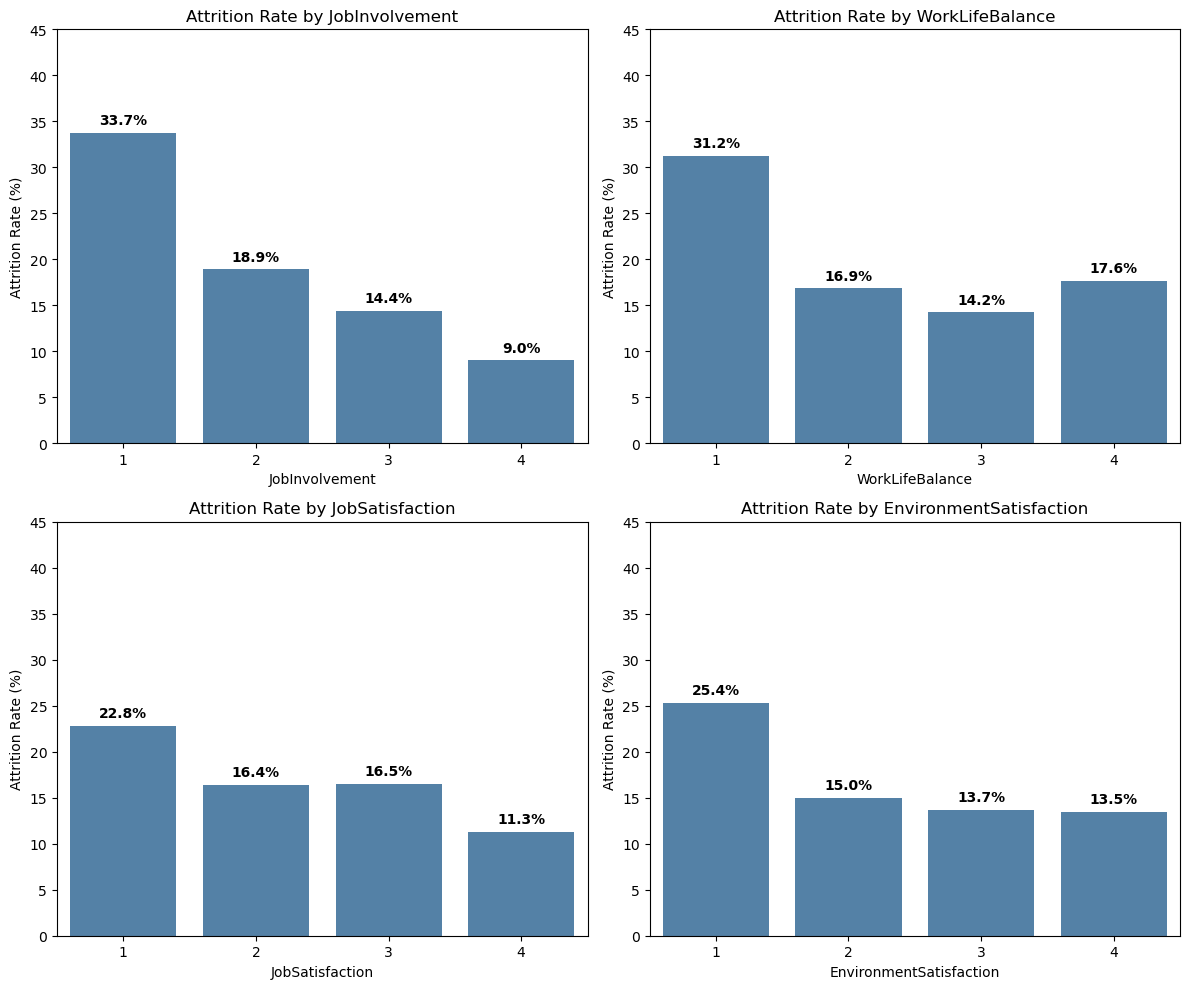

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

ordinal_features = [
    "JobInvolvement",
    "WorkLifeBalance",
    "JobSatisfaction",
    "EnvironmentSatisfaction",
]

for ax, col in zip(axes, ordinal_features):
    plot_df = (
        df.groupby(col)["Attrition"]
        .apply(lambda x: (x == "Yes").mean() * 100)
        .reset_index()
    )

    sns.barplot(data=plot_df, x=col, y="Attrition", ax=ax, color="steelblue")

    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), ".1f") + "%",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 9),
            textcoords="offset points",
            fontsize=10,
            fontweight="bold",
        )

    ax.set_title(f"Attrition Rate by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Attrition Rate (%)")
    ax.set_ylim(0, 45)

plt.tight_layout()
plt.show()

## Ordinal Scale Summary (Top Drivers)

The combined visualization of ordinal scale features highlights clear patterns:

- JobInvolvement shows the strongest and most monotonic relationship with attrition.
- WorkLifeBalance exhibits a sharp increase in attrition at the lowest level (1).
- JobSatisfaction and EnvironmentSatisfaction show moderate but consistent gradients.
- Lower ordinal levels (especially level 1) are consistently associated with higher attrition.

Overall, ordinal scale features capture employee engagement and well-being dimensions that are strongly linked to attrition risk.

## Feature Ideas (from Ordinal Scales)

Candidate engineered features to validate later:
- engagement_index = mean of (JobInvolvement, WorkLifeBalance, JobSatisfaction, EnvironmentSatisfaction)
- low_engagement_flag (1 if engagement_index <= threshold)
- individual ordinal features with strongest signal (e.g., JobInvolvement)

Rationale:
- Multiple ordinal scales measure related aspects of employee engagement.
- A composite index may reduce noise and improve interpretability.

In [15]:
jobrole_counts = df["JobRole"].value_counts()

jobrole_attrition = (
    df.groupby("JobRole")["Attrition"]
    .apply(lambda x: (x == "Yes").mean() * 100)
    .round(2)
)

jobrole_counts, jobrole_attrition

(JobRole
 Sales Executive              326
 Research Scientist           292
 Laboratory Technician        259
 Manufacturing Director       145
 Healthcare Representative    131
 Manager                      102
 Sales Representative          83
 Research Director             80
 Human Resources               52
 Name: count, dtype: int64,
 JobRole
 Healthcare Representative     6.87
 Human Resources              23.08
 Laboratory Technician        23.94
 Manager                       4.90
 Manufacturing Director        6.90
 Research Director             2.50
 Research Scientist           16.10
 Sales Executive              17.48
 Sales Representative         39.76
 Name: Attrition, dtype: float64)

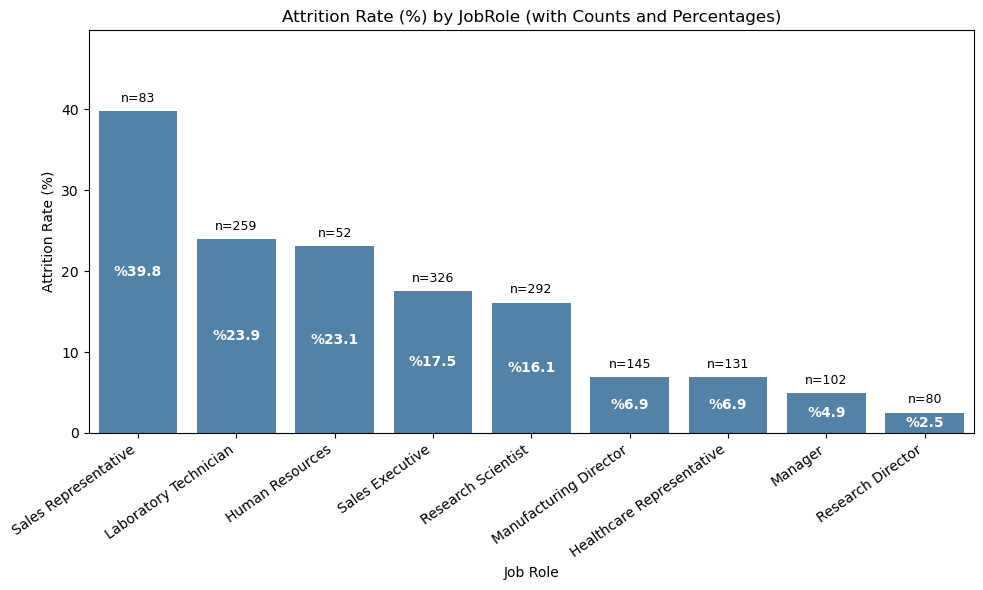

In [20]:
role_df = (
    df.groupby("JobRole")
    .agg(
        count=("Attrition", "size"),
        attrition_rate=("Attrition", lambda x: (x == "Yes").mean() * 100),
    )
    .reset_index()
)

role_df = role_df.sort_values("attrition_rate", ascending=False)


plt.figure(figsize=(10, 6))
ax = sns.barplot(data=role_df, x="JobRole", y="attrition_rate", color="steelblue")


for i, row in enumerate(role_df.itertuples(index=False)):

    ax.text(
        i,
        row.attrition_rate + 0.8,
        f"n={int(row.count)}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="black",
    )

    ax.text(
        i,
        row.attrition_rate / 2,
        f"%{row.attrition_rate:.1f}",
        ha="center",
        va="center",
        color="white",
        fontweight="bold",
        fontsize=10,
    )

ax.set_title("Attrition Rate (%) by JobRole (with Counts and Percentages)")
ax.set_xlabel("Job Role")
ax.set_ylabel("Attrition Rate (%)")
plt.xticks(rotation=35, ha="right")

plt.ylim(0, max(role_df["attrition_rate"]) + 10)
plt.tight_layout()
plt.show()

## JobRole vs Attrition (Rates and Sample Sizes)

Employee counts by role show meaningful differences in sample size (e.g., Sales Executive 326 vs Human Resources 52).

Key takeaway:
- Attrition risk differs substantially by role, suggesting JobRole is a high-signal categorical driver.
- Roles with smaller counts should be interpreted cautiously; rate differences may be less stable for small groups.


## Feature Ideas (from JobRole)

Candidate engineered features to validate later:
- high_risk_role_flag (1 for roles with high observed attrition and sufficient sample size)
- role_attrition_prior (map each JobRole to its observed attrition rate in training data only)

Notes:
- Use a minimum count threshold when defining high-risk roles to reduce instability from small groups.
- Any role-based prior must be computed using training data only to avoid target leakage during evaluation.

In [18]:
travel_counts = df["BusinessTravel"].value_counts()

travel_attrition = (
    df.groupby("BusinessTravel")["Attrition"]
    .apply(lambda x: (x == "Yes").mean() * 100)
    .round(2)
)

travel_counts, travel_attrition

(BusinessTravel
 Travel_Rarely        1043
 Travel_Frequently     277
 Non-Travel            150
 Name: count, dtype: int64,
 BusinessTravel
 Non-Travel            8.00
 Travel_Frequently    24.91
 Travel_Rarely        14.96
 Name: Attrition, dtype: float64)

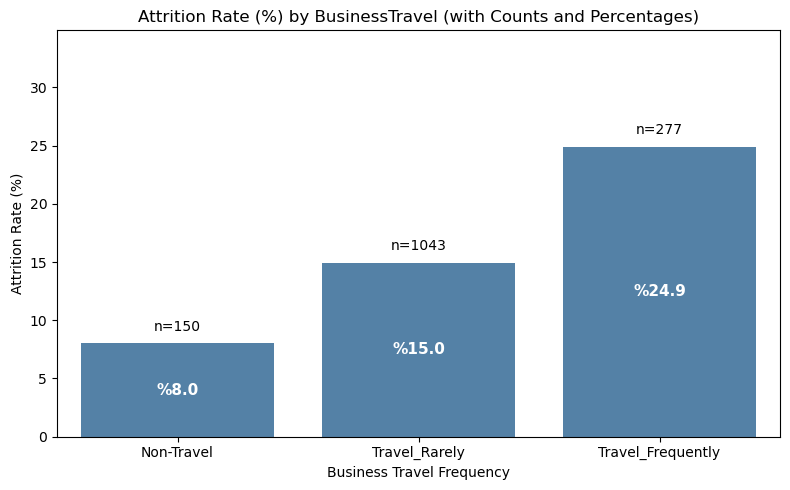

In [21]:
travel_df = (
    df.groupby("BusinessTravel")
    .agg(
        count=("Attrition", "size"),
        attrition_rate=("Attrition", lambda x: (x == "Yes").mean() * 100),
    )
    .reset_index()
)

order = ["Non-Travel", "Travel_Rarely", "Travel_Frequently"]
travel_df["BusinessTravel"] = pd.Categorical(
    travel_df["BusinessTravel"], categories=order, ordered=True
)
travel_df = travel_df.sort_values("BusinessTravel")


plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=travel_df, x="BusinessTravel", y="attrition_rate", color="steelblue"
)


for i, row in enumerate(travel_df.itertuples(index=False)):
    ax.text(
        i,
        row.attrition_rate + 0.8,
        f"n={int(row.count)}",
        ha="center",
        va="bottom",
        fontsize=10,
        color="black",
    )

    if row.attrition_rate > 0:
        ax.text(
            i,
            row.attrition_rate / 2,
            f"%{row.attrition_rate:.1f}",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
            fontsize=11,
        )

ax.set_title("Attrition Rate (%) by BusinessTravel (with Counts and Percentages)")
ax.set_xlabel("Business Travel Frequency")
ax.set_ylabel("Attrition Rate (%)")

plt.ylim(0, max(travel_df["attrition_rate"]) + 10)
plt.tight_layout()
plt.show()

## Visualization Summary: BusinessTravel

The bar chart confirms the earlier rate table:
- Travel_Frequently has the highest attrition rate.
- Non-Travel has the lowest attrition rate.
- Sample sizes are sufficient to treat this as a stable driver (especially Travel_Rarely and Travel_Frequently).

In [22]:
pivot_travel_ot = pd.pivot_table(
    df,
    values="Attrition",
    index="BusinessTravel",
    columns="OverTime",
    aggfunc=lambda x: (x == "Yes").mean() * 100,
).round(2)

pivot_travel_ot

OverTime,No,Yes
BusinessTravel,,
Non-Travel,4.35,20.00
Travel_Frequently,17.28,41.86
Travel_Rarely,9.63,28.47


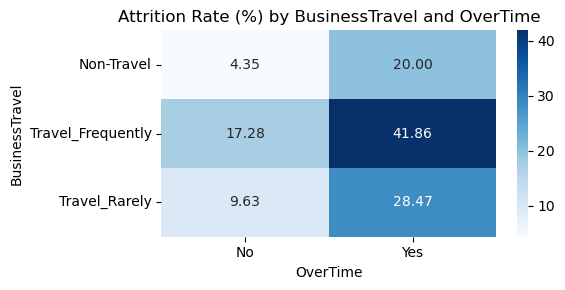

In [23]:
plt.figure(figsize=(6, 3))
sns.heatmap(pivot_travel_ot, annot=True, fmt=".2f", cmap="Blues")
plt.title("Attrition Rate (%) by BusinessTravel and OverTime")
plt.xlabel("OverTime")
plt.ylabel("BusinessTravel")
plt.tight_layout()
plt.show()

Key takeaway:
- OverTime increases attrition risk within every travel category.
- Travel_Frequently combined with OverTime identifies a very high-risk segment (41.86%).
- Even without OverTime, frequent travel remains higher risk than other travel groups.

## Feature Ideas (from BusinessTravel and OverTime Interaction)

Candidate engineered features to validate later:
- frequent_travel_flag (1 if BusinessTravel == "Travel_Frequently")
- frequent_travel_and_overtime (1 if BusinessTravel == "Travel_Frequently" and OverTime == "Yes")
- travel_intensity (map Non-Travel < Travel_Rarely < Travel_Frequently as an ordinal feature)

Rationale:
- Travel frequency has a strong main effect and a clear interaction with OverTime.
- These features are interpretable and can support targeted HR interventions.

In [24]:
marital_counts = df["MaritalStatus"].value_counts()

marital_attrition = (
    df.groupby("MaritalStatus")["Attrition"]
    .apply(lambda x: (x == "Yes").mean() * 100)
    .round(2)
)

marital_counts, marital_attrition

(MaritalStatus
 Married     673
 Single      470
 Divorced    327
 Name: count, dtype: int64,
 MaritalStatus
 Divorced    10.09
 Married     12.48
 Single      25.53
 Name: Attrition, dtype: float64)

(MaritalStatus
 Married     673
 Single      470
 Divorced    327
 Name: count, dtype: int64,
 MaritalStatus
 Divorced    10.09
 Married     12.48
 Single      25.53
 Name: Attrition, dtype: float64)

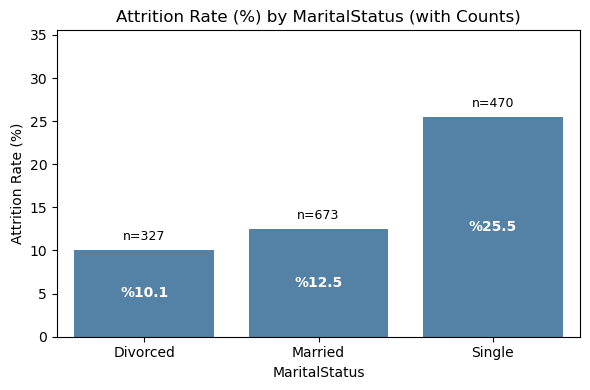

In [26]:
marital_df = (
    df.groupby("MaritalStatus")
    .agg(
        count=("Attrition", "size"),
        attrition_rate=("Attrition", lambda x: (x == "Yes").mean() * 100),
    )
    .reset_index()
)

order = ["Divorced", "Married", "Single"]
marital_df["MaritalStatus"] = pd.Categorical(
    marital_df["MaritalStatus"], categories=order, ordered=True
)
marital_df = marital_df.sort_values("MaritalStatus")

plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=marital_df, x="MaritalStatus", y="attrition_rate", color="steelblue"
)
ax.set_title("Attrition Rate (%) by MaritalStatus (with Counts)")
ax.set_xlabel("MaritalStatus")
ax.set_ylabel("Attrition Rate (%)")

for i, row in enumerate(marital_df.itertuples(index=False)):
    ax.text(
        i,
        row.attrition_rate + 0.8,
        f"n={int(row.count)}",
        ha="center",
        va="bottom",
        fontsize=9,
    )
    ax.text(
        i,
        row.attrition_rate / 2,
        f"%{row.attrition_rate:.1f}",
        ha="center",
        va="center",
        color="white",
        fontweight="bold",
        fontsize=10,
    )

plt.ylim(0, max(marital_df["attrition_rate"]) + 10)
plt.tight_layout()
plt.show()

## Visualization Summary: MaritalStatus

The bar chart confirms the earlier rate table:
- Single employees have the highest attrition rate (25.53%).
- Married and Divorced groups show notably lower attrition (12.48% and 10.09%).
- The distribution of counts supports treating this as a stable driver.

In [27]:
dept_counts = df["Department"].value_counts()

dept_attrition = (
    df.groupby("Department")["Attrition"]
    .apply(lambda x: (x == "Yes").mean() * 100)
    .round(2)
)

dept_counts, dept_attrition

(Department
 Research & Development    961
 Sales                     446
 Human Resources            63
 Name: count, dtype: int64,
 Department
 Human Resources           19.05
 Research & Development    13.84
 Sales                     20.63
 Name: Attrition, dtype: float64)

## Department vs Attrition (Rates and Sample Sizes)

Counts:
- Research & Development: 961
- Sales: 446
- Human Resources: 63

Attrition rate (%):
- Sales: 20.63
- Human Resources: 19.05
- Research & Development: 13.84

Key takeaway:
- Attrition rates differ moderately by department.
- Sales shows the highest attrition, but JobRole provides a more granular and informative signal than Department.
- Human Resources has a small sample size and should be interpreted cautiously.

In [ ]:
cat_summary_rows = []

for col in cat_cols:
    tmp = (
        df.groupby(col)["Attrition"]
        .agg(count="size", attrition_rate=lambda x: (x == "Yes").mean() * 100)
        .reset_index()
        .rename(columns={col: "category"})
    )
    tmp["feature"] = col
    cat_summary_rows.append(tmp)

cat_summary_long = pd.concat(cat_summary_rows, ignore_index=True)
cat_summary_long["attrition_rate"] = cat_summary_long["attrition_rate"].round(2)

cat_summary_long.sort_values(
    ["feature", "attrition_rate"], ascending=[True, False]
).head(25)

,category,count,attrition_rate,feature
1,Travel_Frequently,277,24.91,BusinessTravel
2,Travel_Rarely,1043,14.96,BusinessTravel
0,Non-Travel,150,8.00,BusinessTravel
5,Sales,446,20.63,Department
3,Human Resources,63,19.05,Department
4,Research & Development,961,13.84,Department
6,Human Resources,27,25.93,EducationField
11,Technical Degree,132,24.24,EducationField
8,Marketing,159,22.01,EducationField
7,Life Sciences,606,14.69,EducationField


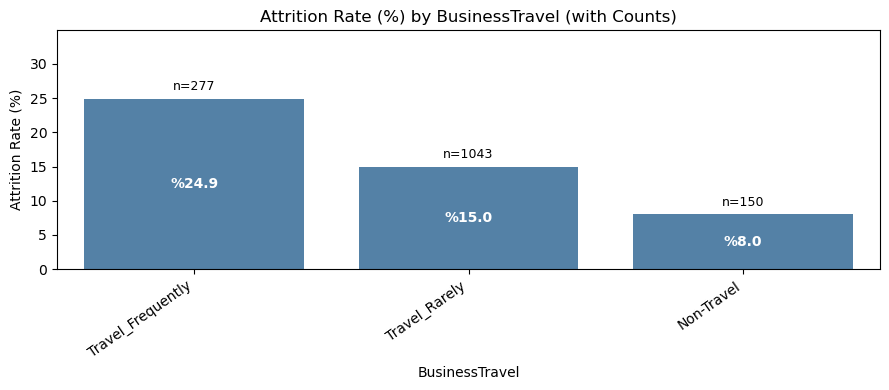

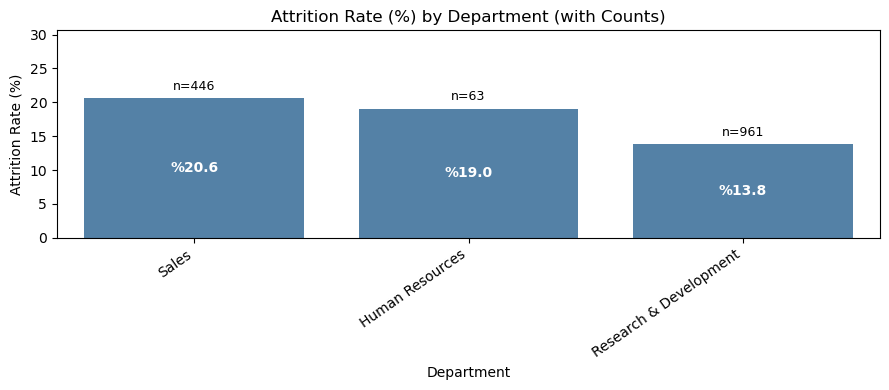

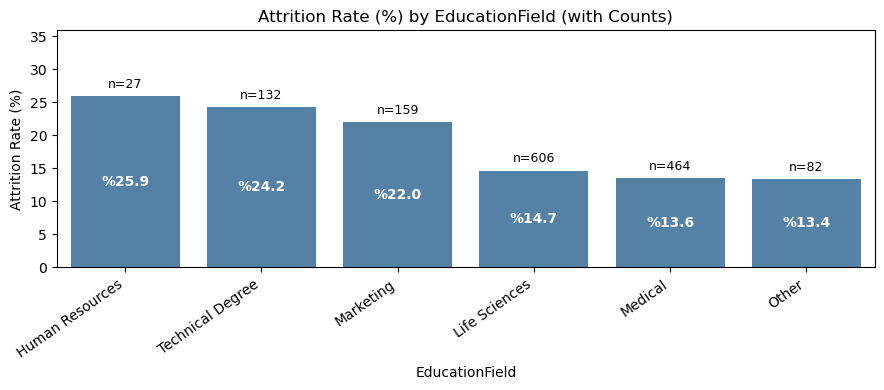

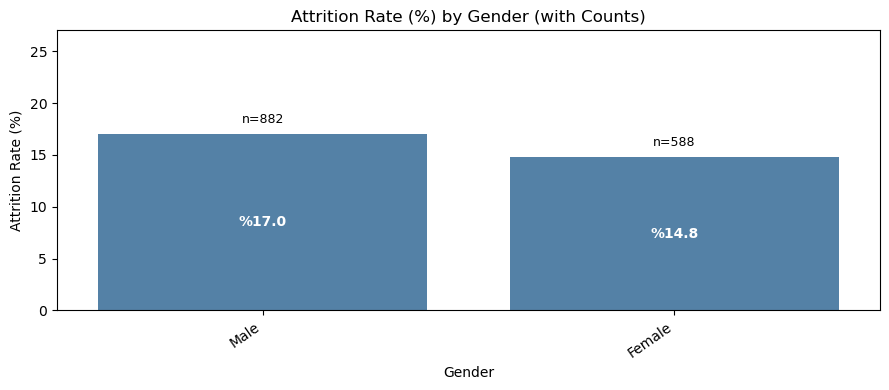

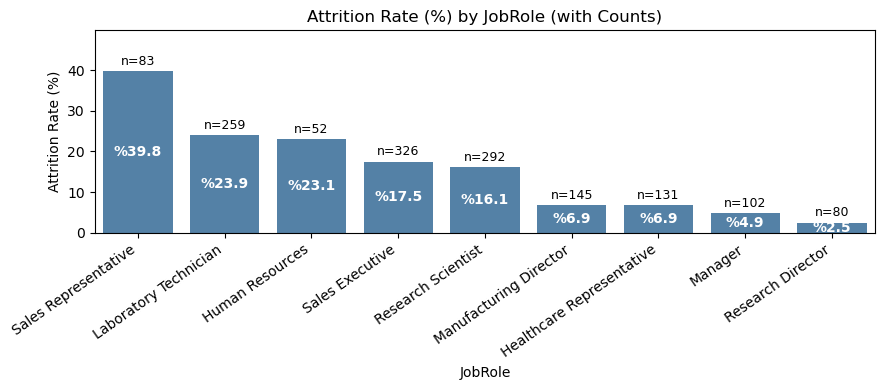

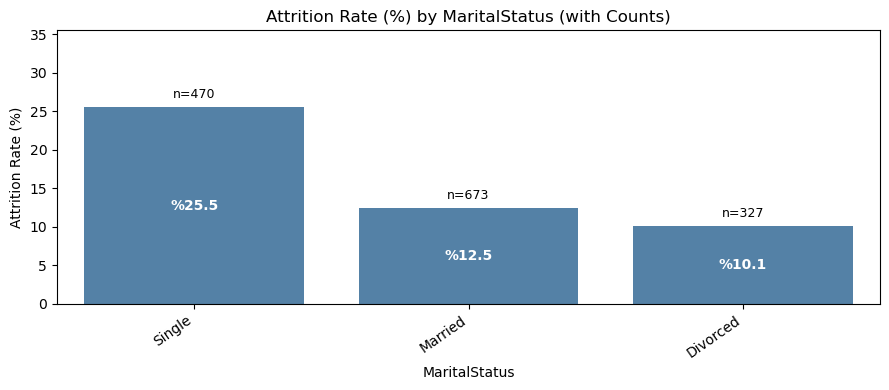

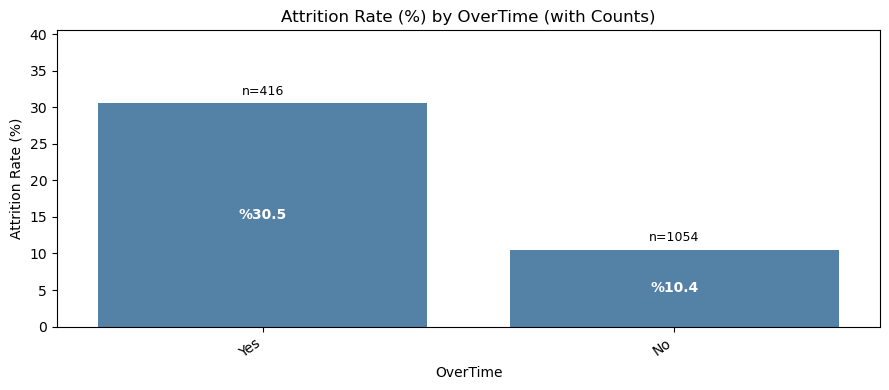

In [ ]:
for col in cat_cols:
    tmp = (
        df.groupby(col)
        .agg(
            count=("Attrition", "size"),
            attrition_rate=("Attrition", lambda x: (x == "Yes").mean() * 100),
        )
        .reset_index()
        .sort_values("attrition_rate", ascending=False)
    )

    plt.figure(figsize=(9, 4))
    ax = sns.barplot(data=tmp, x=col, y="attrition_rate", color="steelblue")
    ax.set_title(f"Attrition Rate (%) by {col} (with Counts)")
    ax.set_xlabel(col)
    ax.set_ylabel("Attrition Rate (%)")
    plt.xticks(rotation=35, ha="right")

    for i, row in enumerate(tmp.itertuples(index=False)):
        ax.text(
            i,
            row.attrition_rate + 0.8,
            f"n={int(row.count)}",
            ha="center",
            va="bottom",
            fontsize=9,
        )
        ax.text(
            i,
            row.attrition_rate / 2,
            f"%{row.attrition_rate:.1f}",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
            fontsize=10,
        )

    plt.ylim(0, max(tmp["attrition_rate"]) + 10)
    plt.tight_layout()
    plt.show()

## Categorical Scan (All Categorical Features)

A systematic scan of all categorical features confirms multiple high-signal drivers:

- BusinessTravel:
  - Travel_Frequently shows a higher attrition rate than Travel_Rarely and Non-Travel.
- Department:
  - Sales shows higher attrition than Research and Development.
- EducationField:
  - Human Resources, Technical Degree, and Marketing show higher attrition rates than the largest groups (Life Sciences, Medical).
  - Some categories have smaller sample sizes and should be interpreted cautiously.
- Gender:
  - Male shows a moderately higher attrition rate than Female.
- JobRole:
  - Large spread in attrition rates, with Sales Representative notably high and Research Director notably low.
- MaritalStatus:
  - Single shows substantially higher attrition than Married.

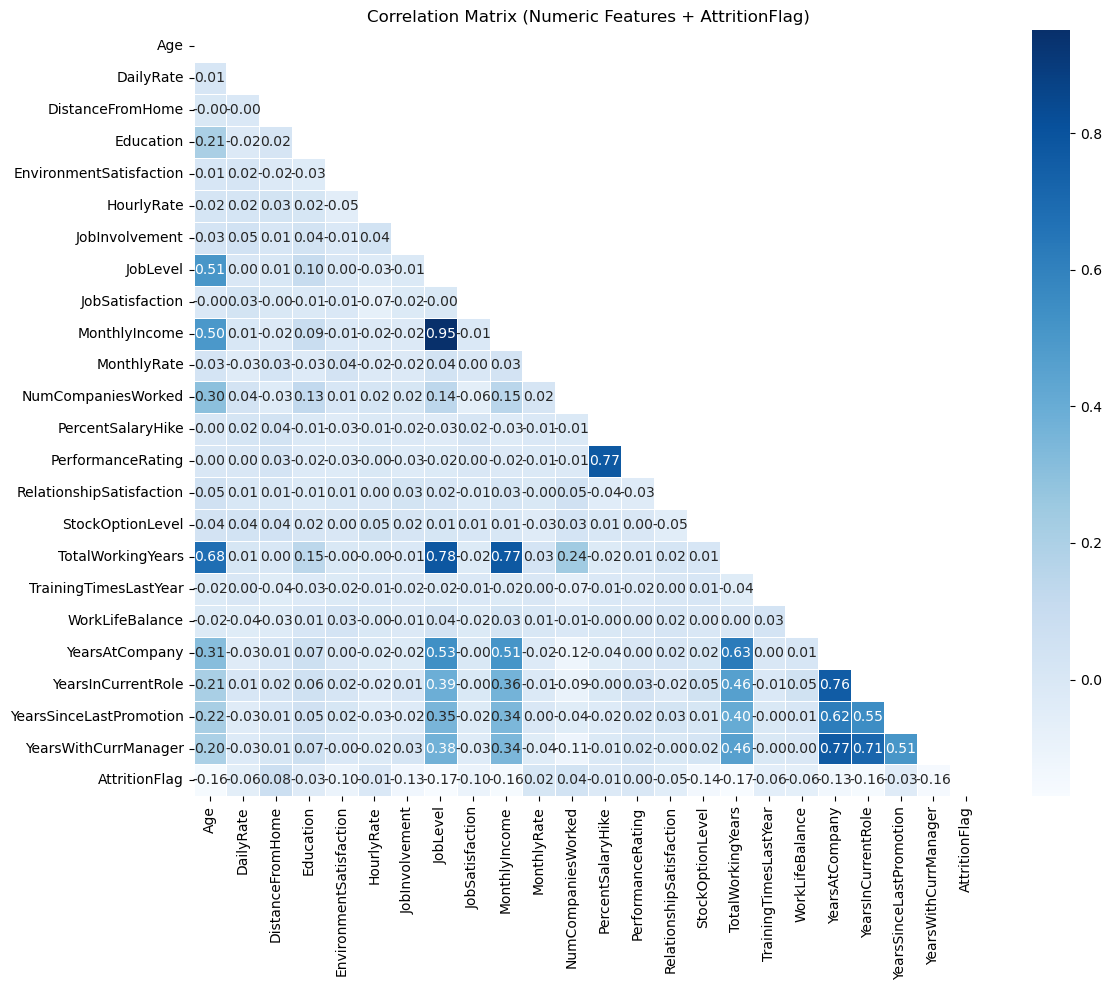

In [40]:
import numpy as np

df_corr = df.copy()
df_corr["AttritionFlag"] = (df_corr["Attrition"] == "Yes").astype(int)

corr_cols = [c for c in num_cols if c in df_corr.columns] + ["AttritionFlag"]
corr = df_corr[corr_cols].corr(numeric_only=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap="Blues", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Numeric Features + AttritionFlag)")
plt.tight_layout()
plt.show()

In [ ]:
top_corr = (
    corr["AttritionFlag"]
    .drop("AttritionFlag")
    .sort_values(key=lambda s: s.abs(), ascending=False)
)
top_corr.head(15)

TotalWorkingYears         -0.171063
JobLevel                  -0.169105
YearsInCurrentRole        -0.160545
MonthlyIncome             -0.159840
Age                       -0.159205
YearsWithCurrManager      -0.156199
StockOptionLevel          -0.137145
YearsAtCompany            -0.134392
JobInvolvement            -0.130016
JobSatisfaction           -0.103481
EnvironmentSatisfaction   -0.103369
DistanceFromHome           0.077924
WorkLifeBalance           -0.063939
TrainingTimesLastYear     -0.059478
DailyRate                 -0.056652
Name: AttritionFlag, dtype: float64

## Correlation Matrix Notes (Numeric Features + AttritionFlag)

Observed correlations with AttritionFlag are relatively small in magnitude (top absolute values around 0.13 to 0.17). This is not an error.

Reasons:
- Pearson correlation captures primarily linear relationships.
- Several drivers identified earlier show non-linear effects (e.g., income quartiles, tenure buckets).
- Some of the strongest drivers are categorical and interaction-based (e.g., OverTime, BusinessTravel, JobRole), which are not represented well by simple numeric correlation.
- With a binary target, Pearson correlations are often modest even when variables are predictive.

Conclusion:
- Correlation is treated as a screening tool, not a definitive measure of feature importance for this problem.

In [ ]:
cont_vars = [
    "MonthlyIncome",
    "Age",
    "YearsAtCompany",
    "TotalWorkingYears",
    "DistanceFromHome",
]

bucket_summary = []

for col in cont_vars:
    tmp = df[[col, "Attrition"]].copy()
    tmp["bucket"] = pd.qcut(tmp[col], q=4, duplicates="drop")

    rates = (
        tmp.groupby("bucket")["Attrition"]
        .apply(lambda x: (x == "Yes").mean() * 100)
        .round(2)
    )
    counts = tmp["bucket"].value_counts().sort_index()

    out = (
        pd.DataFrame({"count": counts, "attrition_rate": rates})
        .reset_index()
        .rename(columns={"index": "bucket"})
    )

    out["feature"] = col
    bucket_summary.append(out)

bucket_summary_df = pd.concat(bucket_summary, ignore_index=True)
bucket_summary_df

C:\Users\alikm\AppData\Local\Temp\ipykernel_12092\1196525415.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = tmp.groupby("bucket")["Attrition"].apply(lambda x: (x == "Yes").mean() * 100).round(2)
C:\Users\alikm\AppData\Local\Temp\ipykernel_12092\1196525415.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = tmp.groupby("bucket")["Attrition"].apply(lambda x: (x == "Yes").mean() * 100).round(2)
C:\Users\alikm\AppData\Local\Temp\ipykernel_12092\1196525415.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=F

,bucket,count,attrition_rate,feature
0,"(1008.999, 2911.0]",369,29.27,MonthlyIncome
1,"(2911.0, 4919.0]",366,14.21,MonthlyIncome
2,"(4919.0, 8379.0]",367,10.63,MonthlyIncome
3,"(8379.0, 19999.0]",368,10.33,MonthlyIncome
4,"(17.999, 30.0]",386,25.91,Age
5,"(30.0, 36.0]",412,16.02,Age
6,"(36.0, 43.0]",325,8.92,Age
7,"(43.0, 60.0]",347,12.10,Age
8,"(-0.001, 3.0]",470,25.96,YearsAtCompany
9,"(3.0, 5.0]",306,13.07,YearsAtCompany


## Why Correlations Look Small: Evidence from Bucketed Effects

Bucketed attrition rates reveal strong non-linear patterns that Pearson correlation does not capture well.

Examples (attrition rate % by quartile):
- MonthlyIncome:
  - Lowest quartile: 29.27
  - Highest quartile: 10.33
  - Large risk drop occurs mainly between Q1 and Q2 (non-linear).

- Age:
  - Youngest quartile: 25.91
  - Middle (36-43): 8.92
  - Pattern is not strictly monotonic (non-linear).

- YearsAtCompany:
  - Lowest quartile (<=3 years): 25.96
  - Higher quartiles: ~10 to 13
  - Early tenure is a distinct high-risk phase.

- TotalWorkingYears:
  - Lowest quartile (<=6 years): 25.62
  - Highest quartile: 8.71
  - Strong gradient across experience levels.

- DistanceFromHome:
  - Highest distance quartile: 20.56
  - Lowest distance quartile: 12.89
  - Effect is positive and clearer when viewed in buckets.

Conclusion:
- Modest Pearson correlations are consistent with meaningful, decision-relevant non-linear effects.
- Bucket features and interaction features are appropriate for this problem.

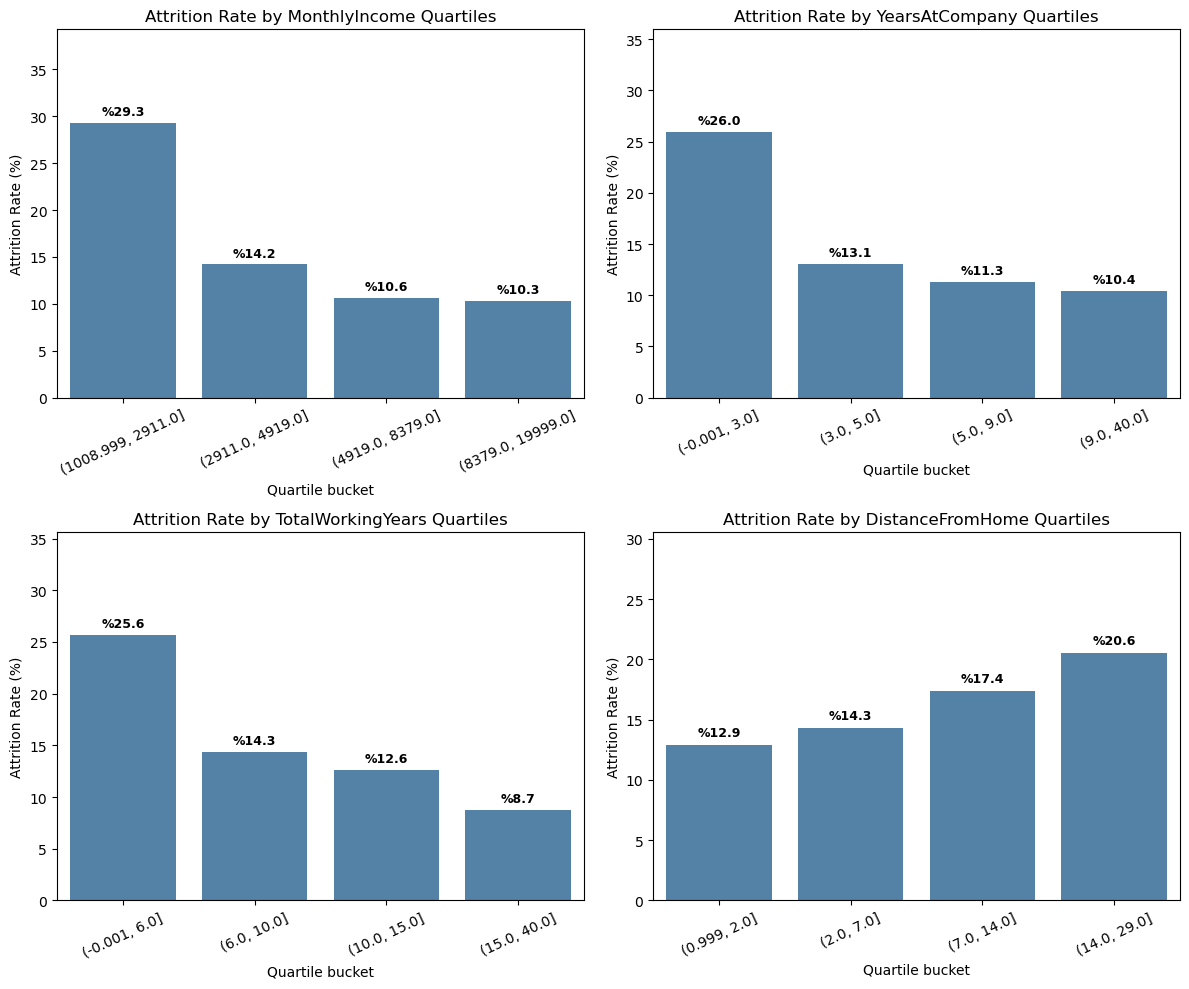

In [ ]:
features_to_plot = [
    "MonthlyIncome",
    "YearsAtCompany",
    "TotalWorkingYears",
    "DistanceFromHome",
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, features_to_plot):
    tmp = df[[col, "Attrition"]].copy()
    tmp["bucket"] = pd.qcut(tmp[col], q=4, duplicates="drop")

    plot_df = (
        tmp.groupby("bucket", observed=False)["Attrition"]
        .apply(lambda x: (x == "Yes").mean() * 100)
        .reset_index()
        .rename(columns={"Attrition": "attrition_rate"})
    )

    sns.barplot(data=plot_df, x="bucket", y="attrition_rate", ax=ax, color="steelblue")

    for i, val in enumerate(plot_df["attrition_rate"]):
        ax.text(
            i,
            val + 0.5,
            f"%{val:.1f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
        )

    ax.set_title(f"Attrition Rate by {col} Quartiles")
    ax.set_xlabel("Quartile bucket")
    ax.set_ylabel("Attrition Rate (%)")
    ax.tick_params(axis="x", rotation=25)
    ax.set_ylim(0, max(plot_df["attrition_rate"]) + 10)

plt.tight_layout()
plt.show()

## Non-Linear Effects in Continuous Features

The quartile-based visualizations highlight strong non-linear relationships:

- MonthlyIncome:
  - Attrition drops sharply after the lowest income quartile.
- YearsAtCompany:
  - Early tenure employees show significantly higher attrition.
- TotalWorkingYears:
  - Lower experience groups are at substantially higher risk.
- DistanceFromHome:
  - Attrition increases steadily with distance, suggesting a monotonic but non-linear effect.

These patterns explain why simple linear correlations are modest despite clear separation in risk across buckets.

In [ ]:
cont_cols = [
    "Age",
    "MonthlyIncome",
    "MonthlyRate",
    "DailyRate",
    "DistanceFromHome",
    "TotalWorkingYears",
    "YearsAtCompany",
]

outlier_rows = []

for col in cont_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_pct = round(outlier_count / len(df) * 100, 2)

    outlier_rows.append(
        {
            "feature": col,
            "outlier_count": outlier_count,
            "outlier_pct": outlier_pct,
            "lower_bound": lower,
            "upper_bound": upper,
        }
    )

outlier_df = pd.DataFrame(outlier_rows).sort_values("outlier_pct", ascending=False)
outlier_df

,feature,outlier_count,outlier_pct,lower_bound,upper_bound
1,MonthlyIncome,114,7.76,-5291.00,16581.00
6,YearsAtCompany,104,7.07,-6.00,18.00
5,TotalWorkingYears,63,4.29,-7.50,28.50
0,Age,0,0.00,10.50,62.50
2,MonthlyRate,0,0.00,-10574.75,39083.25
3,DailyRate,0,0.00,-573.00,2195.00
4,DistanceFromHome,0,0.00,-16.00,32.00


## Outlier Review (IQR-Based)

Outlier analysis using the IQR method shows:

- MonthlyIncome:
  - Outliers: 7.76%
  - These represent very high earners rather than data errors.
- YearsAtCompany:
  - Outliers: 7.07%
  - Long-tenure employees; values are plausible and meaningful.
- TotalWorkingYears:
  - Outliers: 4.29%
  - Reflect highly experienced employees.

Other continuous features (Age, MonthlyRate, DailyRate, DistanceFromHome) show no meaningful outlier presence.

Conclusion:
- Identified outliers appear to be legitimate extreme values, not data quality issues.
- No outlier removal is performed at the EDA stage.
- If needed, capping or winsorization can be evaluated during modeling for linear models only.

# EDA Summary and Feature Engineering Roadmap

## High-Signal Drivers Identified

### Compensation and experience (non-linear)
- MonthlyIncome shows a strong non-linear effect:
  - Lowest income quartile has materially higher attrition than the other quartiles.
- TotalWorkingYears and YearsAtCompany show clear risk separation:
  - Early tenure (especially <= 3 years) is a distinct high-risk phase.
  - Lower total experience groups show higher attrition.
- Age shows meaningful separation by quartiles, with non-linear behavior.

### Workload and intensity (strong main effects + interactions)
- OverTime is a consistent risk amplifier.
- BusinessTravel is a strong driver:
  - Travel_Frequently has the highest attrition.
- Interaction effects are very strong:
  - Early tenure + OverTime produces the highest observed segment-level risk.
  - Travel_Frequently + OverTime identifies a very high-risk segment.
  - Low income + OverTime shows a strong combined risk pattern.

### Engagement and satisfaction (ordinal scales)
- Ordinal scale features show consistent gradients:
  - JobInvolvement is the strongest and most monotonic driver.
  - WorkLifeBalance shows elevated risk at the lowest level.
  - JobSatisfaction and EnvironmentSatisfaction show moderate, consistent effects.
- RelationshipSatisfaction appears weaker/less monotonic compared with other scales.

### Structural and demographic (categorical)
- JobRole shows large dispersion in attrition rates:
  - Sales Representative is the highest-risk role among major categories.
  - Some smaller roles (e.g., Human Resources role category) require caution due to sample size.
- MaritalStatus shows a strong pattern:
  - Single employees have substantially higher attrition.
- EducationField shows meaningful differences:
  - Human Resources, Technical Degree, and Marketing have higher attrition than Life Sciences/Medical.
- Gender shows a moderate difference (Male higher than Female).
- Department shows weaker signal than JobRole and should be treated as secondary.

### Distance and commute proxy
- DistanceFromHome shows a positive risk gradient across quartiles:
  - Higher distance quartiles exhibit higher attrition.

## High-Risk Segments Observed (Actionable Cuts)
- OverTime-driven high-risk segments:
  - Early tenure (<= 1 year, and <= 3 years) + OverTime
  - Travel_Frequently + OverTime
  - Low income quartile + OverTime
- Structural high-risk segments:
  - Sales Representative (role)
  - Single employees (MaritalStatus == Single)
- Additional risk gradients:
  - Highest DistanceFromHome quartile
  - Lowest JobInvolvement level
  - Lowest WorkLifeBalance level

## Standard EDA Artifacts (Added for Coverage and Robustness)
- Full categorical feature scan (all categorical variables) with consistent visuals and rate tables.
- Correlation matrix (numeric-only) used as a screening tool:
  - Observed linear correlations are modest, consistent with non-linear and interaction-driven effects.
- Outlier review (IQR-based) for key continuous variables:
  - MonthlyIncome, YearsAtCompany, TotalWorkingYears contain legitimate extreme values.
  - No outlier removal performed at EDA stage; capping will be considered only during modeling if needed.

## Planned Feature Engineering (Model-Ready Feature Set)

### Target and core setup
- Target encoding:
  - AttritionFlag = 1 if Attrition == "Yes" else 0

### Binary flags (interpretable)
- overtime_flag (OverTime == "Yes")
- frequent_travel_flag (BusinessTravel == "Travel_Frequently")
- is_single_flag (MaritalStatus == "Single")
- long_distance_flag (DistanceFromHome in top quartile)
- low_income_flag (MonthlyIncome in bottom quartile)
- early_tenure_flag (YearsAtCompany <= 3)
- new_hire_flag (YearsAtCompany <= 1)

### Ordinal / bucketed features (capture non-linearity)
- income_quartile (from MonthlyIncome)
- tenure_bucket (from YearsAtCompany)
- total_working_years_quartile (from TotalWorkingYears)
- distance_quartile (from DistanceFromHome)
- age_quartile (from Age)
- travel_intensity (Non-Travel < Travel_Rarely < Travel_Frequently)

### Interaction features (highest ROI)
- low_income_and_overtime
- early_tenure_and_overtime
- new_hire_and_overtime
- frequent_travel_and_overtime
- long_distance_and_overtime (optional, evaluate)

### Categorical encodings
- one-hot encoding for:
  - JobRole
  - BusinessTravel
  - MaritalStatus
  - EducationField
  - Gender
  - Department (optional, secondary)
- Leakage-safe role priors (optional, advanced):
  - role_attrition_prior computed on training data only

### Composite indices (reduce noise, increase interpretability)
- engagement_index = mean of:
  - JobInvolvement, WorkLifeBalance, JobSatisfaction, EnvironmentSatisfaction
- low_engagement_flag (threshold to be validated during training)

This EDA provides a comprehensive, evidence-based foundation for feature engineering, model comparison, and an interpretable Streamlit attrition risk dashboard.
